The notebook contains data analysis that aims to identify product (SKU) and customer characteristics that can be used further for price modelling as well as for contextual bandits. 

<a id="0">Content:</a> <br>
1. [Data review](#data)  
1. [SKU: Time series analysis](#ts)     
1. [EDA](#eda)
    1. [Customers](#users)
    1. [Products (SKU)](#sku)
    1. [Price elasticity](#elasticity)
    1. [Competitors / discounts](#c/e) 

In [7]:
import pandas as pd
import numpy as np

import datetime
import holidays
from calendar import monthrange

from itertools import product
import copy
import json

from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme("paper")

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [290]:
import sys
sys.path.append('..')

from lib.data import get_data, get_ts_periods

In [48]:
PATH = '/Users/andreichekunov/andrei/hard_ml/dynamic pricing/final project dynamic pricing/data/'
PATH_ARTEFACTS = '../artefacts/'

# <a id="data">Data review</a> 

In [282]:
# cost prices
pd.read_csv(PATH + '/wholesale_trade_table.csv').head()

SKU  year  week_num  month  cost_price
0  10060  2019         1     12      2211.0
1  10060  2019        15      4      2454.0
2  10060  2019        16      4      2432.0
3  10060  2019        17      4      2449.0
4  10060  2019        18      4      2280.0

In [283]:
# sales plan / back bonuses
pd.read_csv(PATH + '/sales_plan.csv').head()

SKU  year  month  plan  back_bonus
0  10290  2018      2  20.0      120000
1  10290  2018      3  60.0      140000
2  10290  2018      4  70.0      140000
3  10290  2018      5  60.0      140000
4  10290  2018      6  60.0       40000

In [284]:
# promo 
pd.read_csv(PATH + '/promo_df.csv').head()

SKU  week_num  year  discount
0  74430         1  2018      0.15
1  69978         1  2018      0.05
2  81955         1  2018      0.15
3  78953         1  2018      0.10
4  43034         1  2018      0.05

In [316]:
# competitors prices
pd.read_csv(PATH + '/canc_df.csv').head()

year  week_num    SKU  ret_net_1_price  ret_net_2_price  ret_net_3_price
0  2019         1  10121      2945.681342      2965.743797      2917.394830
1  2019         1  10290       949.466060       942.301292       962.799009
2  2019         1  10973      3751.515022      3735.814981      3709.586540
3  2019         1  11179      3717.042306      3638.799082      3695.090121
4  2019         1  11680      1378.797669      1325.251312      1363.707489

In [278]:
# SKU characteristics
pd.read_csv(PATH + '/sample_1000.csv').head()

sku_id fincode ui1_code ui2_code ui3_code  vendor brand_code creation_date  \
0   16663      Z8      Z81    Z8100  Z810000  FI3ASO   THSTSG81    2018-06-26   
1   91775      Q5      Q51    Q5100  Q510008  4O4WSH   WKXRWTP7    2019-07-07   
2   24641      ZR      ZR1    ZR100  ZR10000  71SM2O   J8XKU94W    2019-05-22   
3   84184      UA      UA1    UA102  UA10205  FI3ASO   5IEJMU4O    2018-04-19   
4   21070      XG      XG1    XG100  XG10000  4O4WSH   4WL34OA2    2019-06-27   

       expiration_date  
0  2019-04-21 00:00:00  
1  2200-01-01 00:00:00  
2  2200-01-01 00:00:00  
3  2019-06-19 00:00:00  
4  2200-01-01 00:00:00

In [11]:
transactions, daily = get_data('daily')
transactions.dates = pd.to_datetime(transactions.dates)
daily.dates = pd.to_datetime(daily.dates)

daily_pred = daily[daily.dates > np.datetime64('2019-11-30')]
daily = daily[daily.dates <= np.datetime64('2019-11-30')]

assert daily.groupby(['SKU', 'dates']).year.count().max() == 1

In [12]:
daily.head()

SKU      dates  price_avg  sales  year  month  weekday  day  \
205862  67369 2018-01-01     3607.0     14  2018      1        0    1   
205863  67369 2018-01-02     3607.0     14  2018      1        1    2   
116856  41262 2018-01-03     3473.0     12  2018      1        2    3   
205864  67369 2018-01-03     3607.0     16  2018      1        2    3   
281503  87418 2018-01-03     2702.0      8  2018      1        2    3   

        week_num  week  ...  ui3_plan  ui1_plan_delta  ui2_plan_delta  \
205862         1     1  ...       1.0             NaN             NaN   
205863         1     1  ...       1.0             NaN             NaN   
116856         1     1  ...       1.0             NaN             NaN   
205864         1     1  ...       1.0             NaN             NaN   
281503         1     1  ...       1.0             NaN             NaN   

       ui3_plan_delta holidays summer  end_of_year  monthlength  plan_per_day  \
205862            NaN     True  False        False            0           inf   
205863            NaN     True  False        False            0           inf   
116856            NaN     True  False        False            0           inf   
205864            NaN     True  False        False            0           inf   
281503            NaN     True  False        False            0           inf   

        mov_avg_price  
205862         3607.0  
205863         3607.0  
116856         3473.0  
205864         3607.0  
281503         2702.0  

[5 rows x 33 columns]

# <a id="ts">SKU: Time series analysis</a> 

#### Historical price variance per SKU

Text(0.5, 1.0, 'price variance')

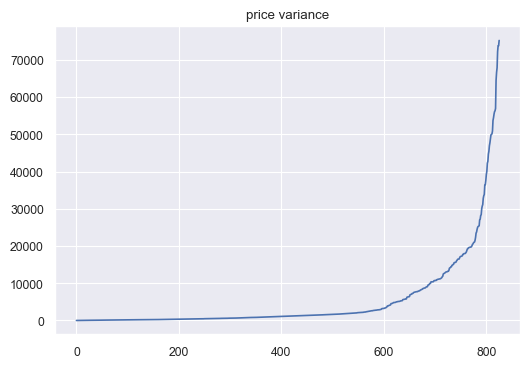

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

all_ts = daily[(daily.actual)].loc[:, ['SKU', 'dates', 'price_avg']].pivot_table(index='dates',
                                                                     columns='SKU', 
                                                                     values='price_avg')
ts_price_var = all_ts.apply(np.var).sort_values()
ts_price_var.reset_index(drop=True).plot(ax=ax)
ax.set_title('price variance')

In [14]:
treshold = 2000
sku_low_var = ts_price_var[ts_price_var<treshold].index
sku_high_var = ts_price_var[ts_price_var>=treshold].index

print(f'n with low_var: {len(sku_low_var)}, \nn with high_var: {len(sku_high_var)}')

n with low_var: 545, 
n with high_var: 281


Text(0.5, 1.0, 'ma sales')

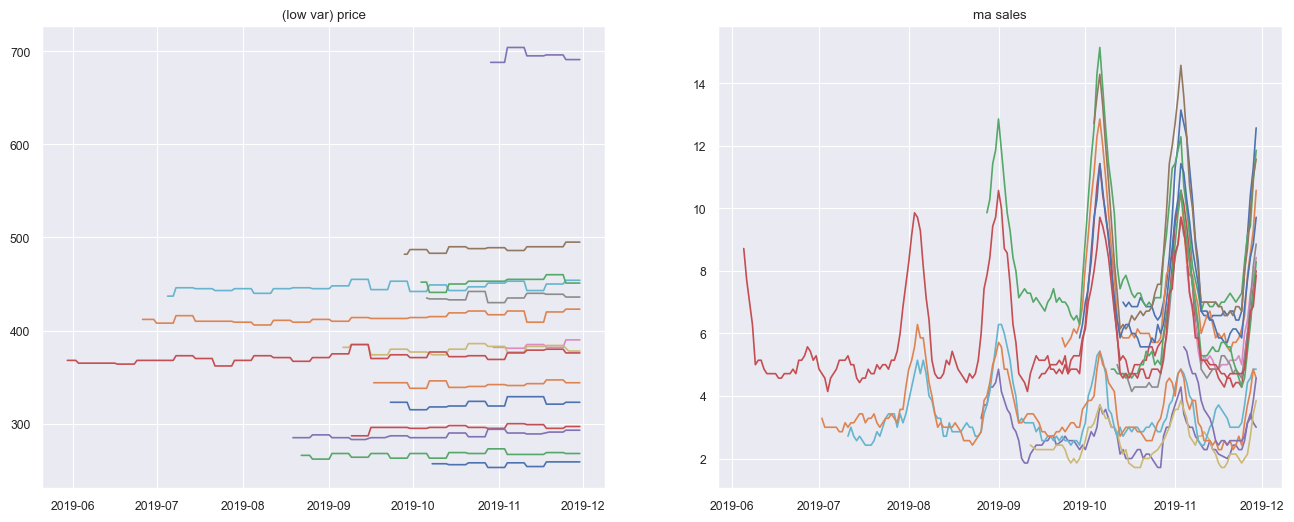

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
for sku in sku_low_var[0:15]:
    df = daily[daily.SKU==sku].loc[:, ['dates', 'price_avg']]
    ax[0].plot(df.dates, df.price_avg)
    
    df = daily[daily.SKU==sku].loc[:, ['dates', 'sales']].sort_values('dates')
    df.sales = df.sales.rolling(7).mean()
    ax[1].plot(df.dates.values[1:-1], df.sales.values[1:-1])
    
ax[0].set_title('(low var) price')
ax[1].set_title('ma sales')

Text(0.5, 1.0, 'ma sales')

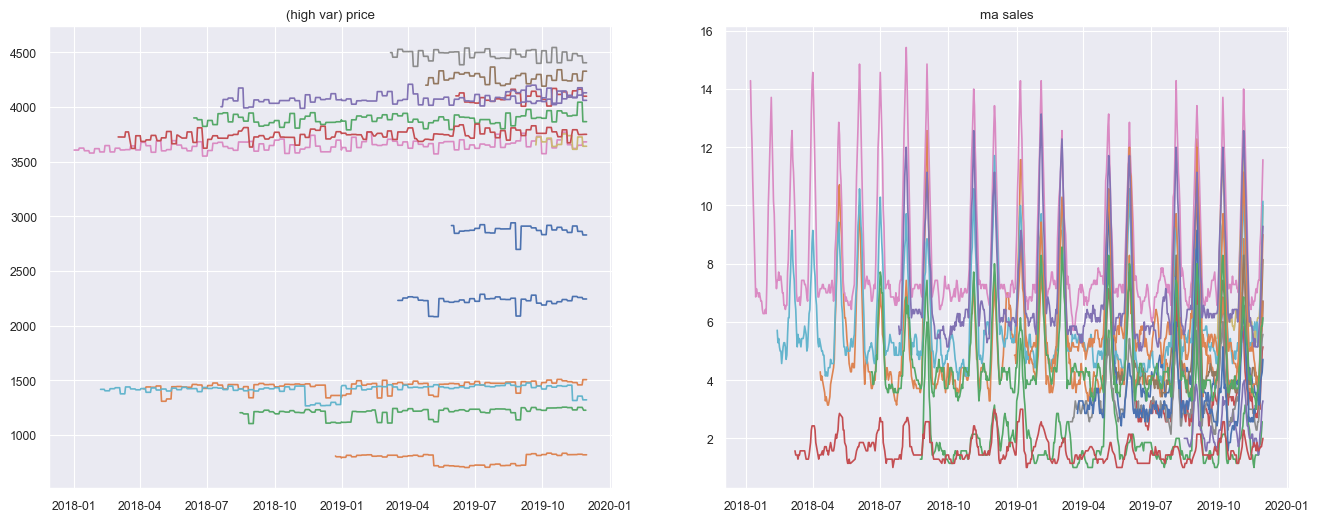

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
for sku in sku_high_var[0:15]:
    df = daily[daily.SKU==sku].loc[:, ['dates', 'price_avg']]
    ax[0].plot(df.dates, df.price_avg)
    
    df = daily[daily.SKU==sku].loc[:, ['dates', 'sales']].sort_values('dates')
    df.sales = df.sales.rolling(7).mean()
    ax[1].plot(df.dates.values[1:-1], df.sales.values[1:-1])
    
ax[0].set_title('(high var) price')
ax[1].set_title('ma sales')

### Clustering

An implicit assumption: difference in historical pricing policy reflects difference of product nature. 

#### Low var

In [457]:
ts_dates = get_ts_periods(daily, sku_low_var)

# min length
T = 120
sku_long = ts_dates[ts_dates['length']>=T].index
sku_short = ts_dates[ts_dates['length']<T].index

print(f'sku_long: {len(sku_long)}')
print(f'sku_short: {len(sku_short)}')

sku_long: 434
sku_short: 111


In [458]:
begin_long = ts_dates.loc[sku_long, :].begin.max()

y = 'price_avg'
all_ts = daily[daily.SKU.isin(sku_long)].loc[:, ['SKU', 'dates', y]].pivot_table(index='dates',
                                                                                   columns='SKU', 
                                                                                   values=y)
for i, sku in enumerate(all_ts.columns):
    all_ts.loc[:, sku] = all_ts.loc[:, sku].ffill()
all_ts = all_ts.dropna()
scaler = StandardScaler()
all_ts_scaled = scaler.fit_transform(all_ts).T

all_ts.shape

(121, 434)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00,  9.81it/s]


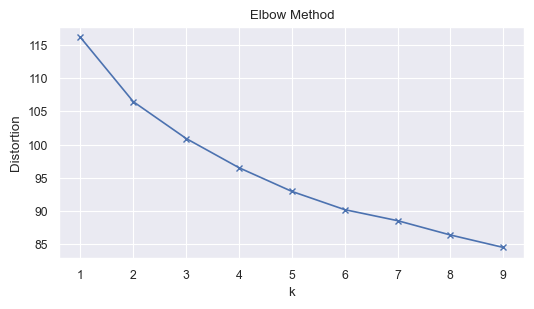

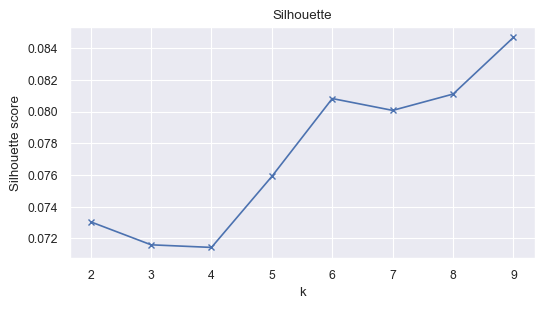

In [459]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric='euclidean', n_jobs=4, max_iter=350)
    kmeanModel.fit(all_ts_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(all_ts_scaled, kmeanModel.labels_))

plt.figure(figsize=(6, 3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

#### High variance

In [17]:
ts_dates = get_ts_periods(daily, sku_high_var)

# min length
T = 120
sku_long = ts_dates[ts_dates['length']>=T].index
sku_short = ts_dates[ts_dates['length']<T].index

print(f'sku_long: {len(sku_long)}')
print(f'sku_short: {len(sku_short)}')

sku_long: 259
sku_short: 22


In [18]:
begin_long = ts_dates.loc[sku_long, :].begin.max()

y = 'price_avg'
all_ts = daily[daily.SKU.isin(sku_long)].loc[:, ['SKU', 'dates', y]].pivot_table(index='dates',
                                                                                   columns='SKU', 
                                                                                   values=y)
for i, sku in enumerate(all_ts.columns):
    all_ts.loc[:, sku] = all_ts.loc[:, sku].ffill()
all_ts = all_ts.dropna()
scaler = StandardScaler()
all_ts_scaled = scaler.fit_transform(all_ts).T

all_ts.shape

(121, 259)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 29.44it/s]


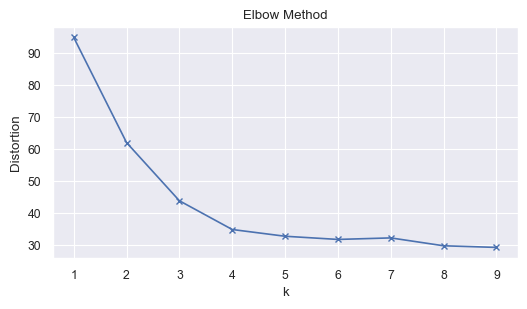

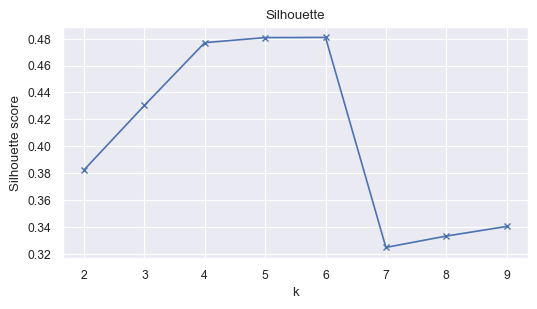

In [19]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric='euclidean', n_jobs=4, max_iter=350)
    kmeanModel.fit(all_ts_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(all_ts_scaled, kmeanModel.labels_))

plt.figure(figsize=(6, 3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [20]:
n_clusters = 4
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=450)
ts_kmeans.fit(all_ts_scaled)

z = dict()
for cluster, sku in zip(ts_kmeans.predict(all_ts_scaled), all_ts.columns):
    if z.get(str(cluster)) is None:
        z[str(cluster)] = [sku]
    else:
        z[str(cluster)] = z[str(cluster)] + [sku]
        
sku_high_var_clusters = copy.deepcopy(z)

for k in sku_high_var_clusters:
    print(k, len(sku_high_var_clusters[k]))

3 100
2 58
0 44
1 57


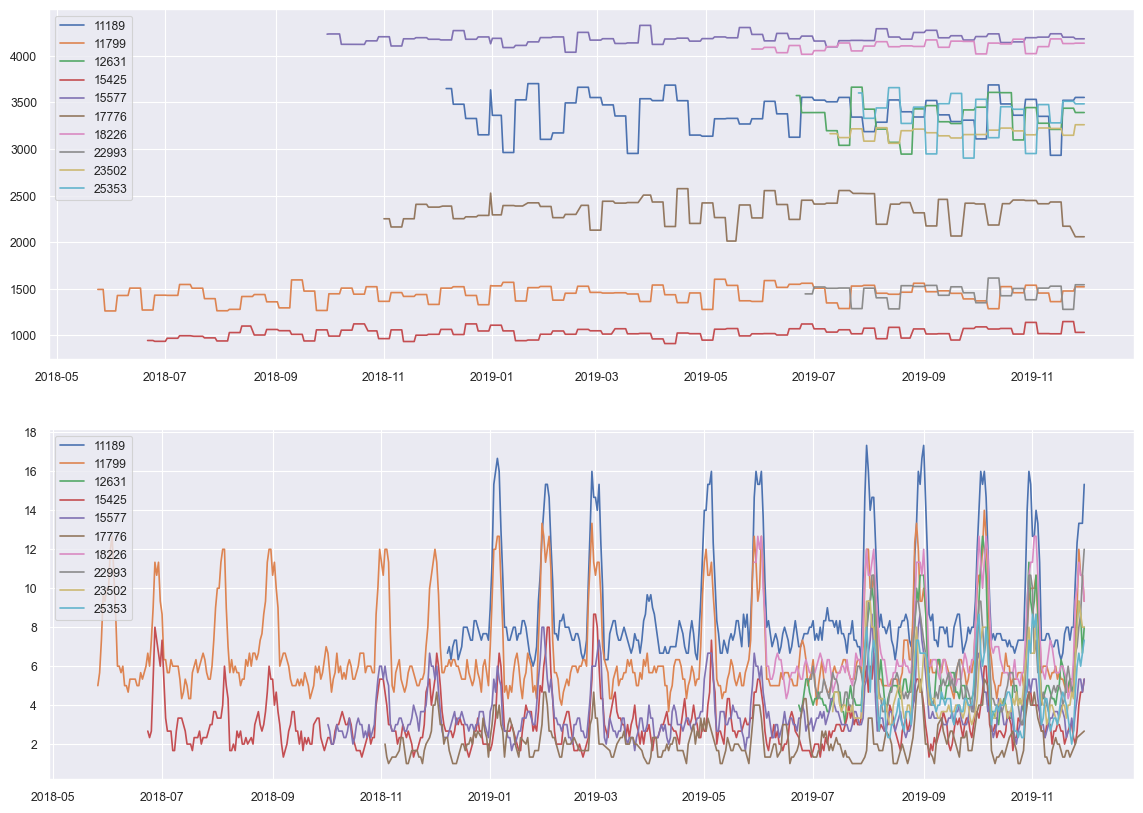

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

for sku in sku_high_var_clusters['0'][:10]:
    #print(sku)
    y = 'price_avg'
    df = daily[daily.SKU==sku].loc[:, ['dates', y]]
    ax[0].plot(df.dates, df[y], label=sku)
    
    y = 'sales'
    df = daily[daily.SKU==sku].loc[:, ['dates', y]]
    ax[1].plot(df.dates, df[y].rolling(3).mean(), label=sku)

ax[1].legend()
ax[0].legend()

In [64]:
sku_classes = {}
sku_classes['class_1'] = sku_high_var_clusters['3'][:]
sku_classes['class_1'].remove(85231)

sku_classes['class_2'] = sku_high_var_clusters['2'][:]
sku_classes['class_2'].remove(16019)
sku_classes['class_2'].remove(42888)
sku_classes['class_2'].remove(43996)

sku_classes['class_3'] = sku_high_var_clusters['1']

sku_classes['high_volatility'] = sku_high_var_clusters['0'] + [16019, 42888, 43996, 85231] + [73037, 47952, 60934, 63638, 49957]

sku_classes['low_var'] = list(map(int, sku_low_var)) 

In [65]:
sku_classes['low_var'] = list(sku_low_var) + list(set(daily[(daily.actual)].SKU.unique()) - set(sku_in))

sku_in = set()
for l in sku_classes.keys():
    sku_in = sku_in|set(sku_classes[l])
    sku_classes[l] = list(map(int, sku_classes[l])) 

assert len(set(daily[(daily.actual)].SKU.unique()) - set(sku_in)) == 0

In [66]:
with open(PATH_ARTEFACTS + '/sku_classes.json', 'w') as outfile:
    json.dump(sku_classes, outfile)

# <a id="eda">EDA</a>

In [67]:
sample_1000 = pd.read_csv(PATH + 'sample_1000.csv')
sample_1000.expiration_date = pd.to_datetime(sample_1000.expiration_date)
sample_1000.creation_date = pd.to_datetime(sample_1000.creation_date)

d = pd.to_datetime('12-01-2019 00:00:00')
sample_1000['actual'] = sample_1000.expiration_date.map(lambda x: x > d)
sample_1000 = sample_1000.rename(columns={'sku_id': 'SKU'})

mean pair: 1.4261485708162556


<AxesSubplot: xlabel='SKU', ylabel='user'>

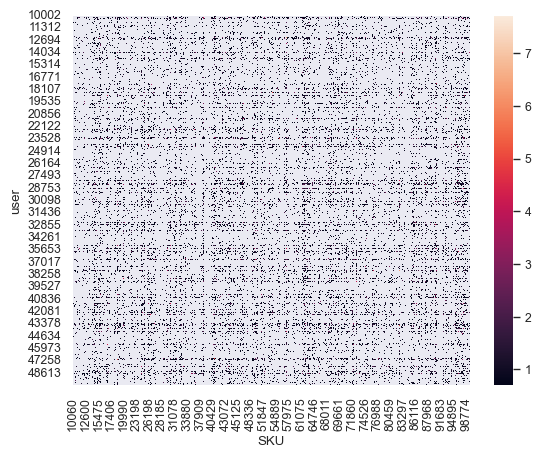

In [68]:
df_heat_map = transactions.pivot_table(index='user', columns='SKU', values='price', aggfunc='count')
print(f'mean pair: {df_heat_map.stack().mean()}')
df_heat_map = (df_heat_map/df_heat_map.stack().mean())
sns.heatmap(df_heat_map)

<AxesSubplot: >

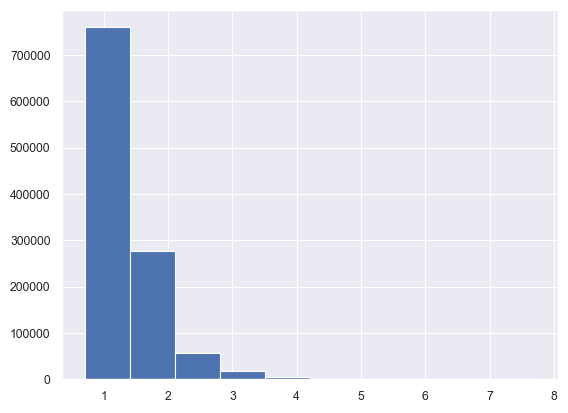

In [94]:
df_heat_map.stack().hist(bins=10)

## <a id="users">Customers</a>

In [299]:
target_users = transactions[transactions.dates > np.datetime64('2019-11-30')].user.unique()
old_users = transactions[transactions.dates <= np.datetime64('2019-11-30')].user.unique()

print(f'target users: {len(set(old_users)&set(target_users))} old, {len(set(target_users)-set(old_users))} new')

target users: 0 old, 0 new


Text(0.5, 1.0, 'user_expenditure')

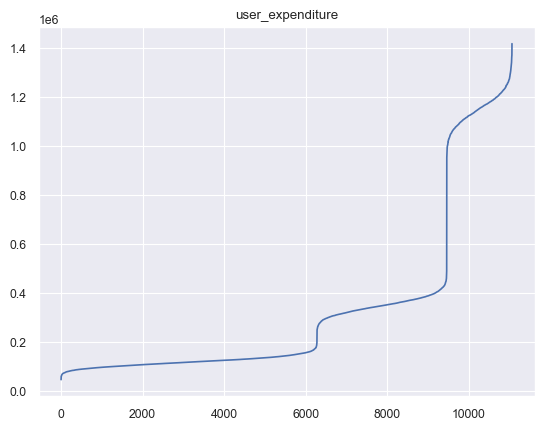

In [71]:
user_expenditure = transactions.groupby(['user'], as_index=False).agg(sum_expend=('price', 'sum'))

plt.plot(range(user_expenditure.shape[0]), user_expenditure.sort_values('sum_expend').sum_expend.values)
plt.title('user_expenditure')

Text(0.5, 1.0, 'user_mean_margin')

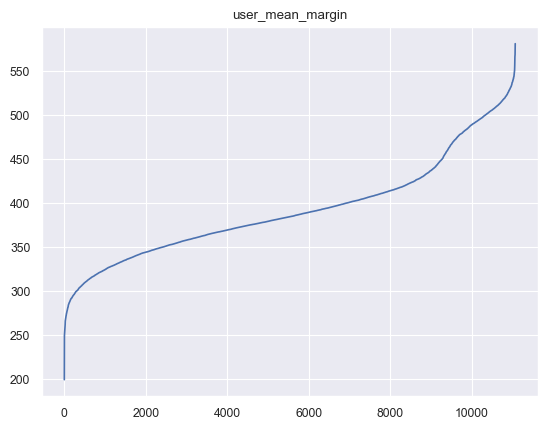

In [72]:
df = transactions.groupby(['dates', 'user'], as_index=False).agg(mean_margin=('margin', 'sum'))
df = df.groupby('user', as_index=False).mean_margin.mean()
mean_margin = df.loc[:, ['user', 'mean_margin']]

plt.plot(range(mean_margin.shape[0]), mean_margin.sort_values('mean_margin').mean_margin.values)
plt.title('user_mean_margin')

Text(0.5, 1.0, 'user_mean_n_sku')

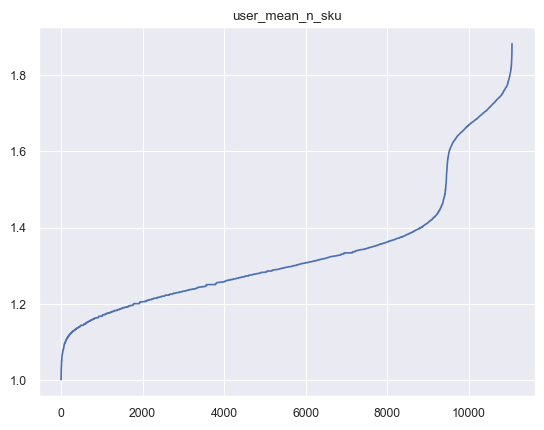

In [74]:
df = transactions.groupby(['dates', 'user'], as_index=False).agg(mean_n_sku=('SKU', 'count'))

df = df.groupby('user', as_index=False).mean_n_sku.mean()
user_mean_n_sku = df.loc[:, ['user', 'mean_n_sku']]

plt.plot(range(user_mean_n_sku.shape[0]), user_mean_n_sku.sort_values('mean_n_sku').mean_n_sku.values)
plt.title('user_mean_n_sku')

Text(0.5, 1.0, 'users')

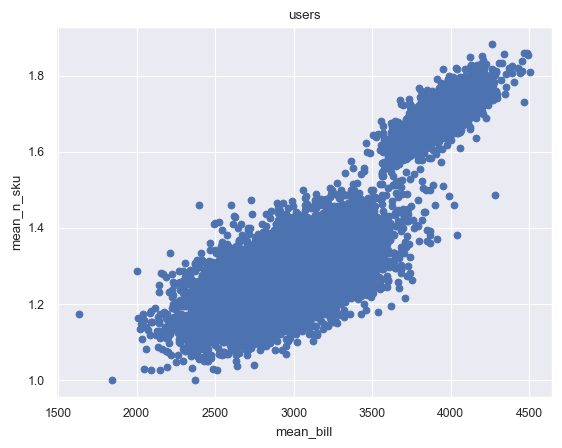

In [75]:
sc = plt.scatter(mean_bill.mean_bill, user_mean_n_sku.mean_n_sku)
plt.ylabel('mean_n_sku')
plt.xlabel('mean_bill')
plt.title('users')

<AxesSubplot: >

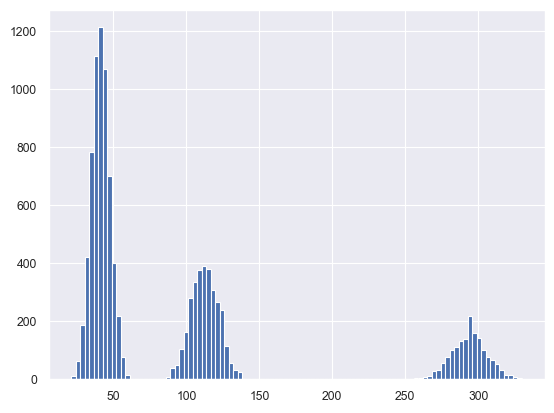

In [77]:
mean_bill.n_visits.hist(bins=100)

In [496]:
# get_user_context - user featuter extractor

from lib.bandits import get_user_context

get_user_context(transactions).sort_values('user')

user    mean_bill  n_visits  last_3_purchases  last_purchase_sum  \
10062  10002  3294.250000        40           10508.0             1168.0   
1852   10003  4386.980328       305            6108.0             1651.0   
10792  10006  3080.194444        36            9055.0             2347.0   
7747   10008  2791.727273        44            8225.0             3309.0   
2310   10009  3053.410256       117           10013.0             1480.0   
...      ...          ...       ...               ...                ...   
10541  49992  2543.973684        38            8366.0              769.0   
1611   49993  3212.393162       117            5922.0             4139.0   
8770   49994  2995.500000        36            8572.0              688.0   
5256   49995  2869.547619        42            7195.0             2373.0   
3682   49999  3038.481132       106            3947.0             2263.0   

       days_in_service  sum_expend_1  sum_expend_2  sum_expend_0  visits_1  \
10062              614             0             0             1         1   
1852               653             0             1             0         0   
10792              649             0             0             1         1   
7747               681             0             0             1         1   
2310               637             1             0             0         0   
...                ...           ...           ...           ...       ...   
10541              466             0             0             1         1   
1611               617             1             0             0         0   
8770               584             0             0             1         1   
5256               673             0             0             1         1   
3682               650             1             0             0         0   

       visits_2  visits_0  old  
10062         0         1    1  
1852          1         1    1  
10792         0         1    1  
7747          0         1    1  
2310          1         1    1  
...         ...       ...  ...  
10541         0         1    1  
1611          1         1    1  
8770          0         1    1  
5256          0         1    1  
3682          1         1    1  

[11062 rows x 13 columns]

## <a id="sku">SKU (products)</a>

In [574]:
sample_1000['month'] = sample_1000['creation_date'].dt.month
sample_1000['year'] = sample_1000['creation_date'].dt.year
sample_1000['age'] = (2019 - sample_1000['year'])*12 + sample_1000['month']

<AxesSubplot: xlabel='SKU', ylabel='weekday'>

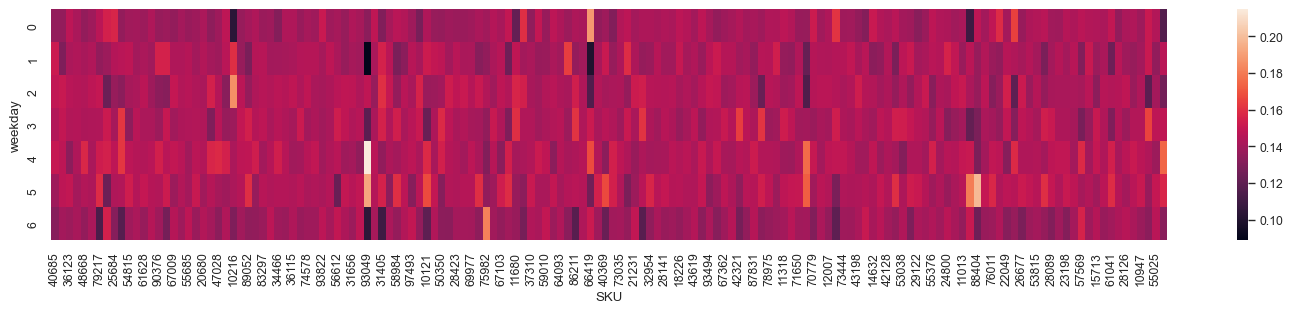

In [575]:
# weekdays

df_sku = transactions[transactions.actual].groupby(['SKU', 'dates'], as_index=False).agg(sales=('price', 'count'),
                                                                       margin=('margin', 'sum'))

df_sku['weekday'] = df_sku['dates'].dt.weekday

df = df_sku.groupby(['SKU', 'weekday'], as_index=False).sales.sum()

fig, ax = plt.subplots(1, 1, figsize=(18, 3))
df_heat_map = df.pivot_table(index='weekday', columns='SKU', values='sales', aggfunc='sum')
ii = np.random.choice(df_heat_map .columns, 150)
df_heat_map = df_heat_map.loc[:, ii]
sns.heatmap((df_heat_map/df_heat_map.sum(axis=0)))

<AxesSubplot: xlabel='SKU', ylabel='month'>

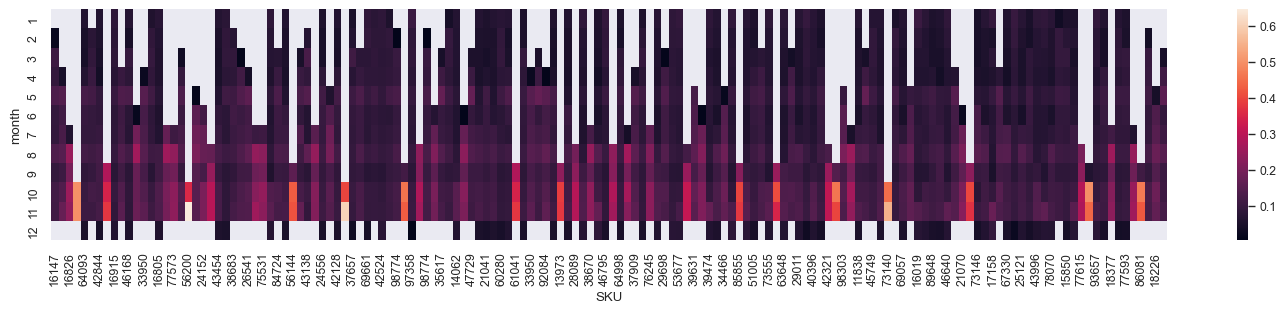

In [576]:
# months

df_sku['month'] = df_sku['dates'].dt.month
df_sku['year'] = df_sku['dates'].dt.year

df = df_sku.groupby(['SKU', 'month'], as_index=False).sales.sum()

fig, ax = plt.subplots(1, 1, figsize=(18, 3))
df_heat_map = df.pivot_table(index='month', columns='SKU', values='sales', aggfunc='sum')
ii = np.random.choice(df_heat_map .columns, 150)
df_heat_map = df_heat_map.loc[:, ii]
sns.heatmap(df_heat_map/df_heat_map.sum(axis=0))

In [589]:
# frequency / marginality

frequency = transactions[transactions.actual]
frequency = frequency.groupby(['SKU'], as_index=False).agg(frequency=('price', 'count'),
                                                           value=('cost_price', 'mean'),
                                                           margin=('margin', 'mean'),
                                                           gain=('margin', 'sum'),
                                                                 )
frequency = frequency.merge(sample_1000.loc[:, ['SKU', 'age']], on='SKU', how='left')
frequency['frequency'] = frequency['frequency'] / frequency['age']
frequency['gain'] = frequency['gain'] / frequency['age']
frequency['gain_clipped'] = frequency['gain'].map(lambda x: np.clip(x, 0, 400000))

<AxesSubplot: title={'center': 'sku sales frequency distr'}>

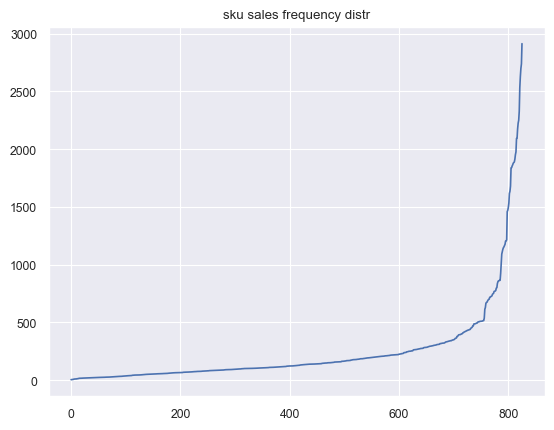

In [590]:
frequency['frequency'].sort_values().reset_index(drop=True).plot(title='sku sales frequency distr')

<AxesSubplot: >

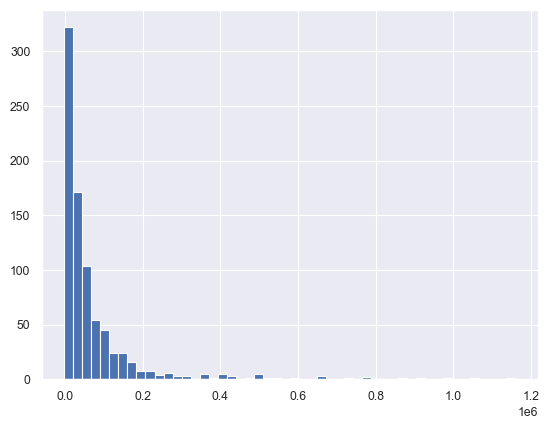

In [591]:
frequency.gain.hist(bins=50)

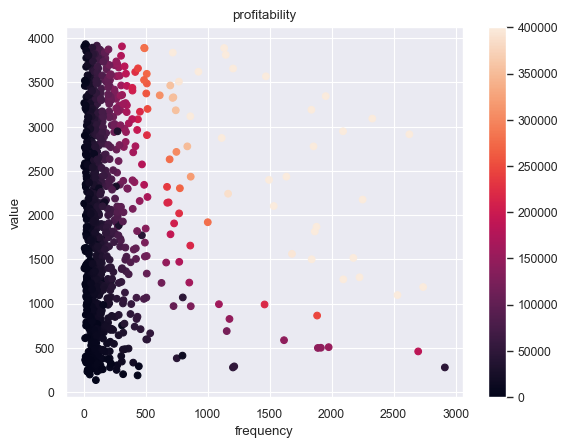

In [582]:
sc = plt.scatter(frequency.frequency, 
                 frequency.value, 
                 c=frequency.gain_clipped)
plt.ylabel('value')
plt.xlabel('frequency')
plt.title('profitability')
plt.colorbar(sc)

In [596]:
sku_features = frequency.drop('gain', axis=1)
for k in range(1, sku_features.shape[1]):
    sku_features.iloc[:, k] = MinMaxScaler().fit_transform(sku_features.iloc[:, k].values.reshape(-1, 1)).flatten()
    
    with open(PATH_ARTEFACTS + '/sku_classes.json', 'r') as json_file:
        sku_classes = json.load(json_file)


for c in sku_classes:
    sku_features[c] = 0
    ii = sku_features[sku_features.SKU.isin(sku_classes[c])].index
    sku_features.loc[ii, c] = 1
    
sku_features['dynamic'] = 1
sku_features['completed'] = 0
sku_features = sku_features.set_index('SKU')
sku_features.index = sku_features.index.map(int)
sku_features = sku_features.drop('margin', axis=1)
sku_features.to_csv(PATH_ARTEFACTS + '/sku_features.csv', sep=',', index=True)

In [597]:
sku_features.head()

frequency     value       age  gain_clipped  class_1  class_2  class_3  \
SKU                                                                             
10060   0.075863  0.597816  0.130435      0.199657        1        0        0   
10121   0.009865  0.632236  0.391304      0.032220        0        0        0   
10216   0.011641  0.795252  0.217391      0.046739        0        1        0   
10230   0.172510  0.245607  0.086957      0.200483        0        0        0   
10388   0.089784  0.686017  0.130435      0.270729        1        0        0   

       high_volatility  low_var  dynamic  completed  
SKU                                                  
10060                0        0        1          0  
10121                0        1        1          0  
10216                0        0        1          0  
10230                0        1        1          0  
10388                0        0        1          0

In [563]:
# classes marginality

frequency.index = frequency.SKU

for c in sku_classes:
    frequency[c] = 0
    ii = frequency[frequency.SKU.isin(sku_classes[c])].index
    frequency.loc[ii, c] = 1

for k in sku_classes.keys():
    m = frequency.loc[sku_classes[k], 'gain'].median()
    print(f'{k} median gain: {m:.2f}, n: {len(sku_classes[k])}')

m = frequency.loc[:, 'gain'].median()
print(f'median gain: {m}')

class_1 median gain: 79862.75, n: 99
class_2 median gain: 57061.53, n: 55
class_3 median gain: 48125.56, n: 57
high_volatility median gain: 15733.89, n: 53
low_var median gain: 25646.58, n: 562
median gain: 32577.141414141413


In [335]:
# backbonuses

sales_plan_pred = sales_plan[(sales_plan.year==2019)&
                             (sales_plan.month==12)].loc[:, ['SKU', 'plan', 'back_bonus', 'back_bonus_spec']]
sales_plan = sales_plan[sales_plan.plan>0]
sales_plan['back_bonus_spec'] = sales_plan['back_bonus'] / sales_plan['plan']

for k in sku_classes.keys():
    bb = sales_plan[sales_plan.SKU.isin(sku_classes[k])].back_bonus_spec.mean()
    print(f'{k} specific bb: {int(bb)}')

bb = sales_plan.back_bonus_spec.mean()
print(f'avg specific bb: {int(bb)}')

sales_plan_pred.to_csv(PATH_ARTEFACTS + 'sales_plan_pred.csv', sep=',', index=True)

class_1 specific bb: 1335
class_2 specific bb: 1470
class_3 specific bb: 1485
high_volatility specific bb: 1400
low_var specific bb: 1512
avg specific bb: 1492


## <a id="elasticity">Price elasticity</a>

In [451]:
def price_elasticity(x):
    E = (x['price_prev'] + x['price'])*(x['sales_prev'] - x['sales'])
    E /= (x['sales_prev'] + x['sales'])*(x['price_prev'] - x['price'])
    return E

def same_price(df_, smoothing=0):
    df = df_.copy()
    df['prev_price'] = df.price.shift(1)
    if smoothing > 0:
        df['price_change'] = (df.price/df.prev_price - 1)
        df['step'] = df['price_change'].map(lambda x: 1 if abs(x)>=smoothing else 0)
    else:
        df['step'] = (df['prev_price'] != df.price).astype(int)
    
    df['step'] = df['step'].cumsum()
    df = df.groupby('step', as_index=False).agg(sales=('sales', 'sum'),
                                                price=('price', 'mean'),
                                                days=('price', 'count'))
    return df

def ger_sku_elastisity(sku, rolling=0, smoothing=0):
    df = transactions[transactions.SKU==sku]
    df = df.groupby('dates', as_index=False).agg(sales=('SKU', 'count'),
                                        price=('price', 'first'),
                                        cost_price=('cost_price', 'first'))
    df = same_price(df, smoothing=smoothing)
    df['sales'] = df['sales']/df['days']
    df['price_prev'] = df['price'].shift(1)
    df['sales_prev'] = df['sales'].shift(1)
    df['price_elasticity'] = df.apply(price_elasticity, axis=1)
    
    df['price_elasticity'] = df['price_elasticity'].map(lambda x: round(x, 0))
    
    return df

In [454]:
elasticity = pd.DataFrame([], index=transactions.SKU.unique())
elasticity['elasticity_median'] = 0
elasticity['hist'] = 0
elasticity['elasticity_var'] = 0

max_seles_price = pd.DataFrame([], index=transactions.SKU.unique())

for sku in transactions.SKU.unique():
    df = ger_sku_elastisity(sku, smoothing=0.05)
    elasticity.loc[sku, 'elasticity_median'] = df.price_elasticity.median()
    elasticity.loc[sku, 'hist'] = df.shape[0]
    elasticity.loc[sku, 'elasticity_var'] = df.price_elasticity.var()

<AxesSubplot: >

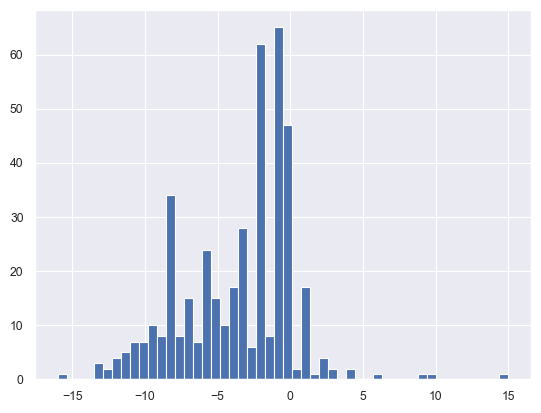

In [455]:
elasticity[elasticity.elasticity_median>-100].elasticity_median.hist(bins=50)

In [285]:
sku = 31103

Text(0.5, 1.0, '31103: sales')

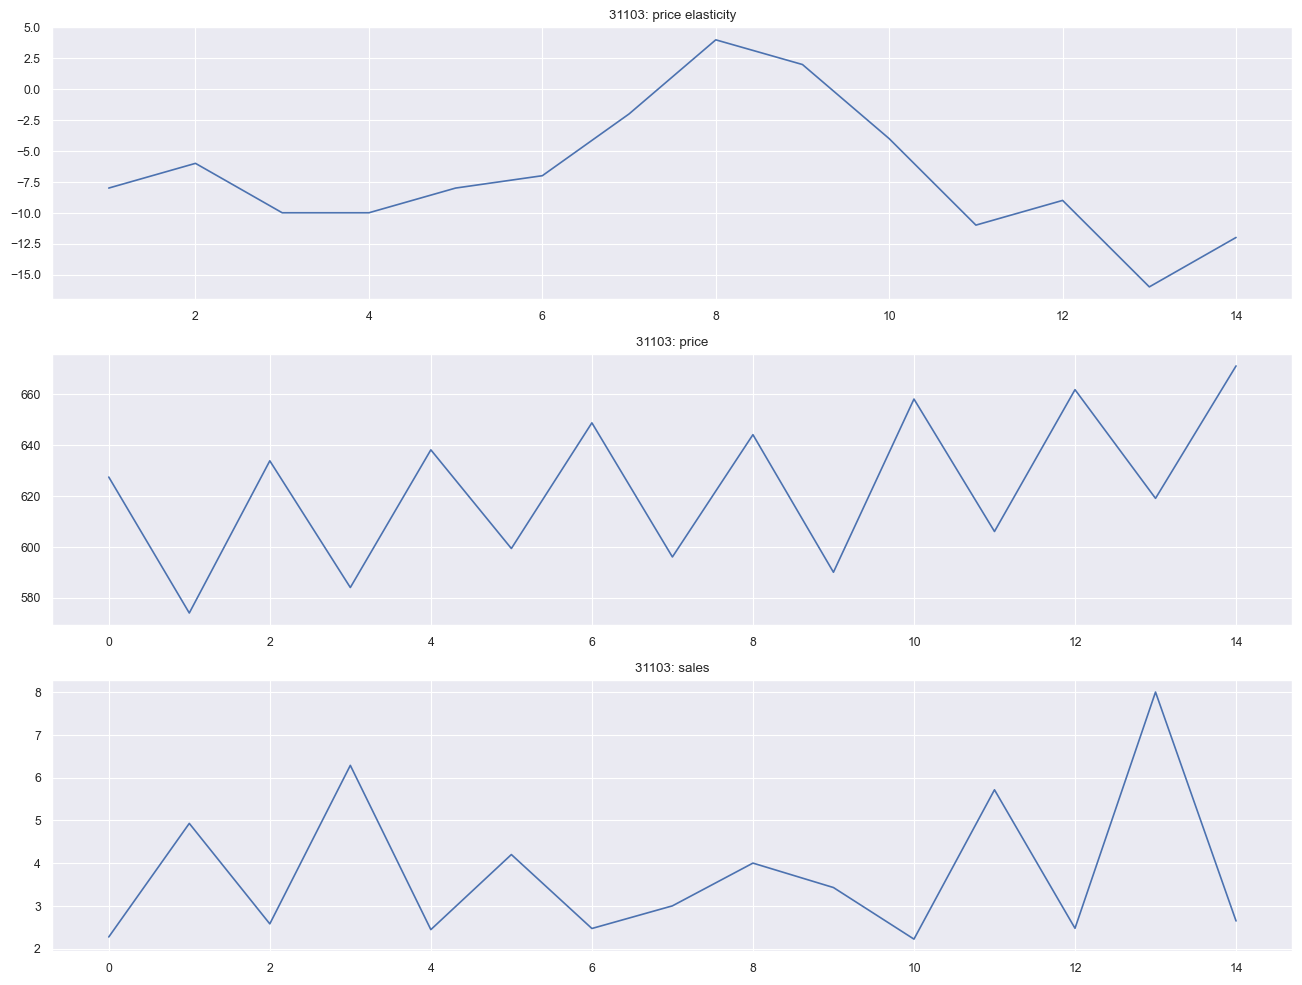

In [286]:
df = ger_sku_elastisity(sku, smoothing=0.05)

fig, ax = plt.subplots(3, 1, figsize=(16, 12))

df.price_elasticity.plot(ax=ax[0])
df.price.plot(ax=ax[1])
df.sales.plot(ax=ax[2])

ax[0].set_title(f'{sku}: price elasticity')
ax[1].set_title(f'{sku}: price')
ax[2].set_title(f'{sku}: sales')

Text(0.5, 1.0, '31103: sales')

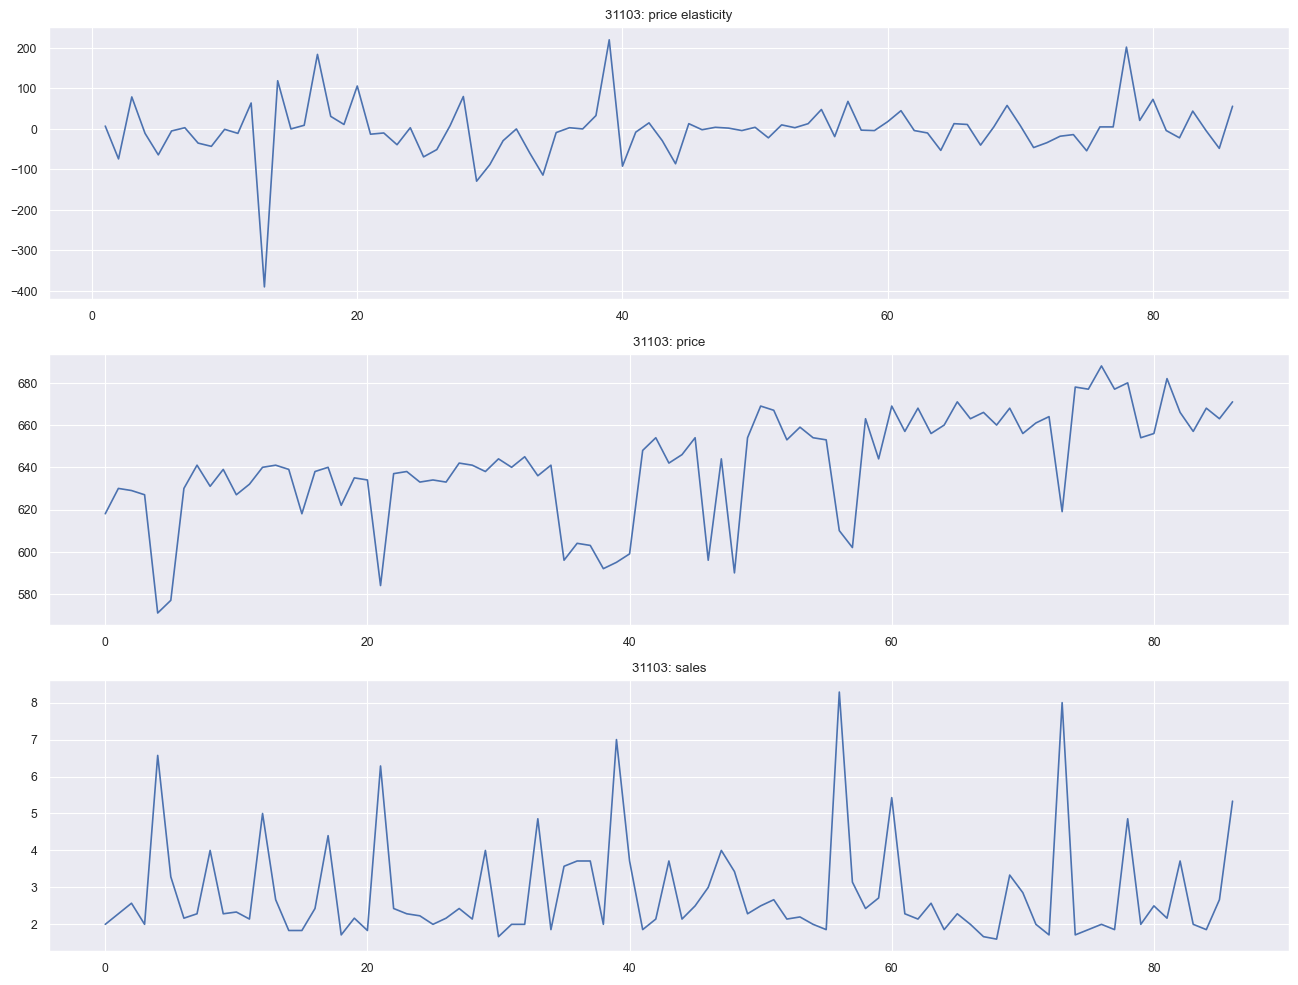

In [287]:
df = ger_sku_elastisity(sku, smoothing=0.00)

fig, ax = plt.subplots(3, 1, figsize=(16, 12))

df.price_elasticity.plot(ax=ax[0])
df.price.plot(ax=ax[1])
df.sales.plot(ax=ax[2])

ax[0].set_title(f'{sku}: price elasticity')
ax[1].set_title(f'{sku}: price')
ax[2].set_title(f'{sku}: sales')

## <a id="c/e">Competitors / discounts</a>

In [138]:
competitors = pd.read_csv(PATH + 'canc_df.csv')
competitors['min_comp_price'] = competitors.iloc[:, -3:].min(axis=1)

In [202]:
for factor in ['discount', 'min_comp_price']:
    for k in sku_classes.keys():
        sku_in = daily[daily.SKU.isin(sku_classes[k])].groupby(['SKU'])[factor].max()
        sku_in = sku_in[sku_in>-100].index
        print(f'{factor}, {k}: {len(sku_in)/len(sku_classes[k]):.2f}')

discount, class_1: 0.00
discount, class_2: 0.00
discount, class_3: 0.02
discount, high_volatility: 0.64
discount, low_var: 0.01
min_comp_price, class_1: 0.26
min_comp_price, class_2: 0.20
min_comp_price, class_3: 0.35
min_comp_price, high_volatility: 0.26
min_comp_price, low_var: 0.30


In [140]:
competitors.head()

year  week_num    SKU  ret_net_1_price  ret_net_2_price  ret_net_3_price  \
0  2019         1  10121      2945.681342      2965.743797      2917.394830   
1  2019         1  10290       949.466060       942.301292       962.799009   
2  2019         1  10973      3751.515022      3735.814981      3709.586540   
3  2019         1  11179      3717.042306      3638.799082      3695.090121   
4  2019         1  11680      1378.797669      1325.251312      1363.707489   

   min_comp_price  
0     2917.394830  
1      942.301292  
2     3709.586540  
3     3638.799082  
4     1325.251312

In [190]:
def factor_price_sales(sku_classes, factor, limit=10):
    fig, ax = plt.subplots(3, 1, figsize=(16, 14))
    sku_in = daily.groupby(['SKU'])[factor].max()
    sku_in = sku_in[sku_in>0].index
    counter = 0
    for sku in set(sku_classes)&set(sku_in):
        for i, c in enumerate(['price_avg', 'sales', factor]):
            df = daily[daily.SKU==sku].loc[:, ['dates', c]].replace({-999: 0})
            ax[i].plot(df.dates, df[c], label=sku)
            ax[i].set_title(c)
        counter += 1
        if counter > limit:
            break

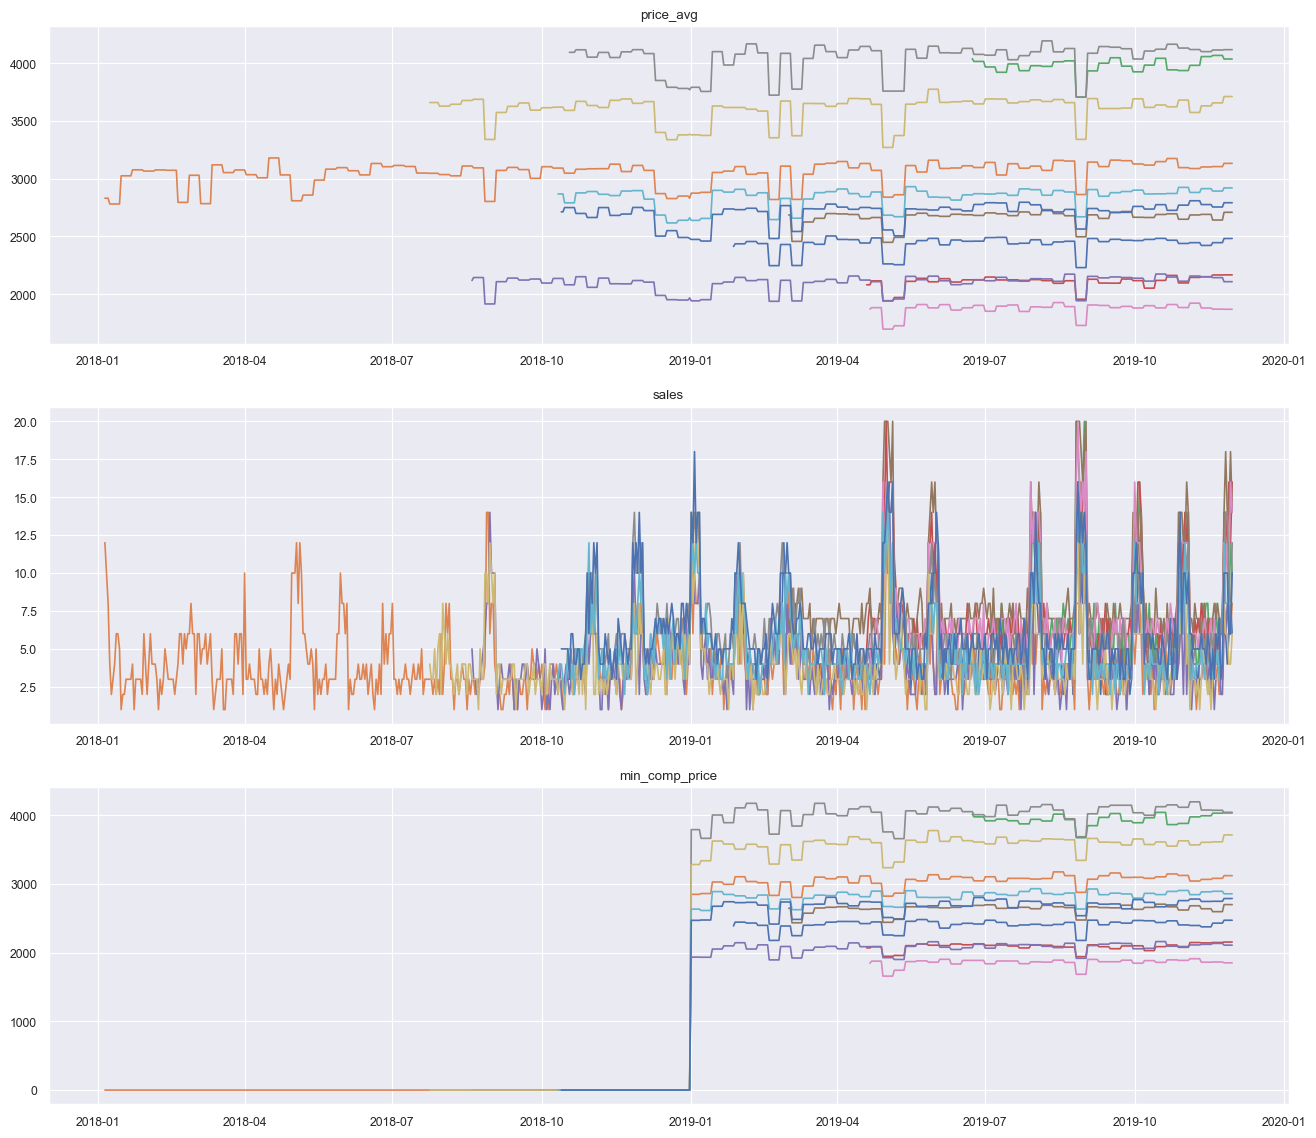

In [191]:
factor_price_sales(sku_classes['class_1'], 'min_comp_price')

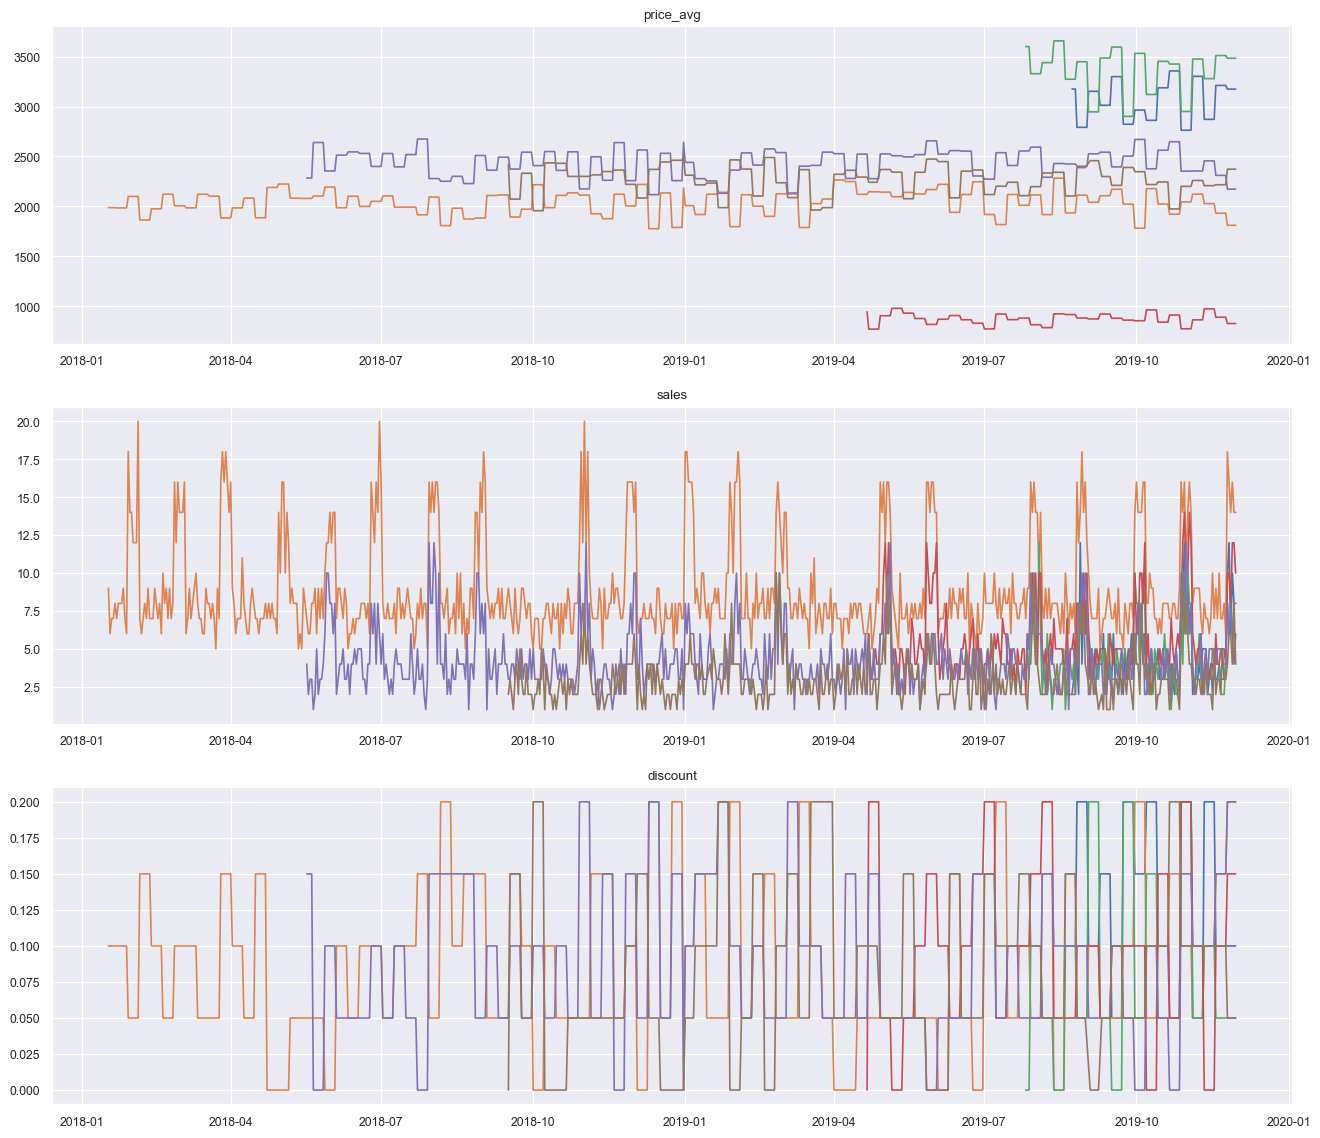

In [193]:
factor_price_sales(sku_classes['high_volatility'], 'discount', limit=5)